# Face Mask Detection
### By Sam Anthony

This is a face mask detection project for UNC's STOR 566 course using the kaggle dataset https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

In [34]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim

from sklearn.model_selection import KFold as kfold
from torch.utils.data import SubsetRandomSampler
import time

In [3]:
!pip install xmltodict

In [4]:
import xmltodict

## Images and XML Labels

In [5]:
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [6]:
path_annotations="/kaggle/input/face-mask-detection/annotations/" 
img_names[14][:-4]
with open(path_annotations+img_names[0][:-4]+".xml") as fd:
    doc = xmltodict.parse(fd.read())
temp = doc["annotation"]["object"]  
temp

{'name': 'with_mask',
 'pose': 'Unspecified',
 'truncated': '0',
 'occluded': '0',
 'difficult': '0',
 'bndbox': {'xmin': '107', 'ymin': '277', 'xmax': '216', 'ymax': '400'}}

In [7]:
# Count the number of samples per mask class
path_annotations="/kaggle/input/face-mask-detection/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc = xmltodict.parse(fd.read())
    temp = doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"]) 
        
Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

dict_keys(['with_mask', 'mask_weared_incorrect', 'without_mask']) 
 dict_values([3232, 123, 717])


## Descriptive Stats Graphs

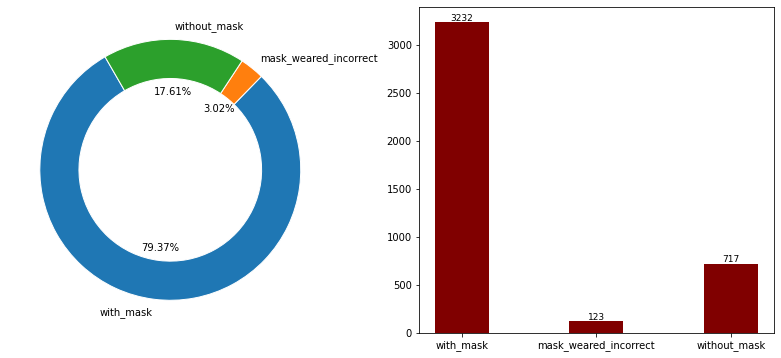

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))

ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')
ax2 = plt.bar(Items, list(values), color ='maroon', width = 0.4, )

index=np.arange(len(list(values)))
for a,b in zip(index, list(values)):
     plt.text(a,b,b,ha='center',va='bottom',fontsize=9)
plt.show()

## Target Class in Image

Red = without_mask

Yellow = mask_weared_incorrect

Green = with_mask

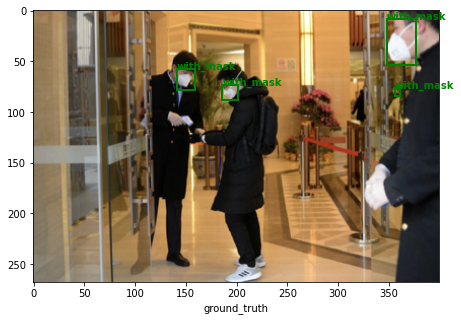

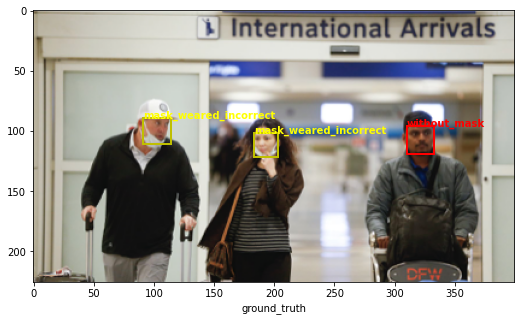

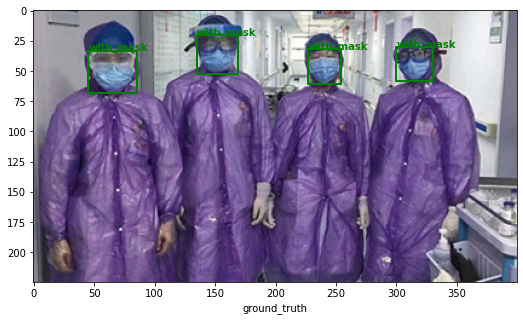

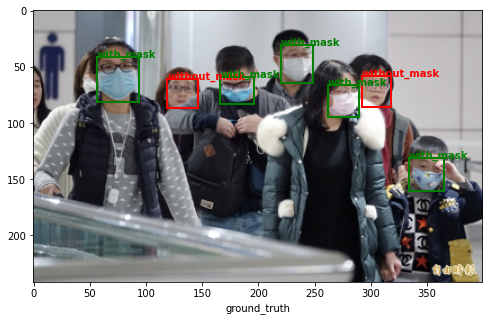

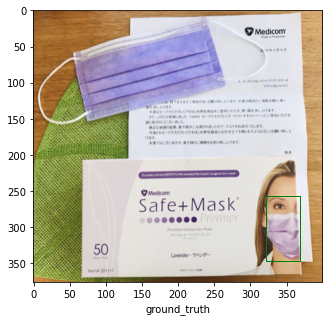

In [9]:
path_image="/kaggle/input/face-mask-detection/images/"  
def face_true(img): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc = xmltodict.parse(fd.read())  
    image = plt.imread(os.path.join(path_image+img))
    fig, ax = plt.subplots(1)
    ax.set_xlabel('ground_truth')
    fig.set_size_inches(10,5)
    
    temp = doc["annotation"]["object"]
    if type(temp) == list:
        for i in range(len(temp)):
            # with_mask
            if temp[i]["name"] == "with_mask":
                x,y,w,h = list(map(int,temp[i]["bndbox"].values()))
                mpatch = mpatches.Rectangle((x,y), (w-x), h-y, linewidth=1, edgecolor='g',facecolor="none", lw=2)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            
            # mask_weared_incorrect
            if temp[i]["name"] == "mask_weared_incorrect":
                x,y,w,h = list(map(int,temp[i]["bndbox"].values()))
                mpatch = mpatches.Rectangle((x,y), w-x, h-y, linewidth=1, edgecolor='y', facecolor="none", lw=2)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
            
            # without_mask
            if temp[i]["name"] == "without_mask":
                x,y,w,h = list(map(int,temp[i]["bndbox"].values()))     
                mpatch = mpatches.Rectangle((x,y), w-x, h-y, linewidth=1, edgecolor='r',facecolor="none",lw=2)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h = list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g", "without_mask":"r", "mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y), w-x, h-y, linewidth=1, edgecolor=edgecolor[temp["name"]], facecolor="none")
    ax.imshow(image)
    ax.add_patch(mpatch)

fun_images = img_names.copy()
for i in range(1,6): 
    face_true(fun_images[i])  

## Image Preprocessing 

In [10]:
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 

In [11]:
class Rotate(object):
    def __init__(self, angle):
        self.angle = angle
    def __call__(self, x, mode="reflect"):
        x = x.rotate(self.angle)
        return x

import random
from PIL import Image
import skimage.io
import skimage.util
class RandomNoise:
    def __init__(self, modes, p=0.5):
        self.modes = modes
        self.p = p
    def __call__(self, image):
        if random.uniform(0, 1) < self.p:
            img_arr = np.array(image)
            for mode in self.modes:
                img_arr = skimage.util.random_noise(img_arr, mode)
            img_pil = Image.fromarray((img_arr * 255).astype(np.uint8))
            return img_pil
        else:
            return image
from torchvision.transforms import RandomVerticalFlip
random_vertical_flip = RandomVerticalFlip(p=1.0) 

In [12]:
def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc = xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"]) != list:
            temp = doc["annotation"]["object"]
            x,y,w,h = list(map(int,temp["bndbox"].values()))
            label = options[temp["name"]]
            image = transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label)) 
            if label==2:
                image_tensor.append(my_transform_rotate(image))
                image_tensor.append(my_transform_Affine(image))
                label_tensor.append(torch.tensor(label))
                label_tensor.append(torch.tensor(label))
                image_tensor.append(my_transform_flip(image))
                label_tensor.append(torch.tensor(label))
        else:
            temp = doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h = list(map(int,temp[k]["bndbox"].values()))
                label = options[temp[k]["name"]]
                image = transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label)) 
                if label==2:
                    image_tensor.append(my_transform_rotate(image))
                    image_tensor.append(my_transform_Affine(image))
                    label_tensor.append(torch.tensor(label))
                    label_tensor.append(torch.tensor(label)) 
                    image_tensor.append(my_transform_flip(image))
                    label_tensor.append(torch.tensor(label))
    final_dataset = [[k,l] for k,l in zip(image_tensor, label_tensor)]
    return tuple(final_dataset)

rotation=180
modess = ['gaussian'] *10
random_noise = RandomNoise(modess, p=0.3)
my_transform = transforms.Compose([transforms.Resize([96,96]),transforms.ToTensor()])
my_transform_rotate = transforms.Compose([transforms.RandomRotation((180), expand=True),transforms.Resize([96,96]),transforms.ToTensor()])
my_transform_Affine = transforms.Compose([transforms.RandomAffine(degrees=0, shear=(0, 0, 0, 45)),transforms.RandomResizedCrop((96, 96)),transforms.ToTensor()])  
my_transform_flip = transforms.Compose([random_vertical_flip,transforms.RandomResizedCrop((96, 96)),transforms.ToTensor()]) 
mydataset = dataset_creation(img_names)

In [13]:
mydataset[0]

[tensor([[[0.3333, 0.4039, 0.4196,  ..., 0.1725, 0.1647, 0.1686],
          [0.3647, 0.3725, 0.4118,  ..., 0.1804, 0.1647, 0.1608],
          [0.2706, 0.2784, 0.2824,  ..., 0.1922, 0.1765, 0.1765],
          ...,
          [0.0824, 0.0824, 0.0706,  ..., 0.6431, 0.6471, 0.6431],
          [0.0745, 0.0745, 0.0667,  ..., 0.6471, 0.6471, 0.6431],
          [0.0706, 0.0627, 0.0510,  ..., 0.6431, 0.6431, 0.6392]],
 
         [[0.3451, 0.4275, 0.4471,  ..., 0.1137, 0.1098, 0.1176],
          [0.3686, 0.3804, 0.4235,  ..., 0.1137, 0.1098, 0.1059],
          [0.2588, 0.2667, 0.2745,  ..., 0.1216, 0.1216, 0.1176],
          ...,
          [0.0745, 0.0745, 0.0667,  ..., 0.4235, 0.4275, 0.4275],
          [0.0706, 0.0667, 0.0667,  ..., 0.4314, 0.4314, 0.4353],
          [0.0706, 0.0627, 0.0510,  ..., 0.4314, 0.4353, 0.4392]],
 
         [[0.3490, 0.4118, 0.4000,  ..., 0.0941, 0.0941, 0.1020],
          [0.3569, 0.3686, 0.4039,  ..., 0.0980, 0.0941, 0.0941],
          [0.2353, 0.2471, 0.2510,  ...,

## Train and Test Set

In [14]:
train_size = int(len(mydataset)*0.7)
test_size = len(mydataset)-train_size
print('Dataset:', len(mydataset), '\nTraining:',train_size,'\nTesting:', test_size)

Dataset: 4441 
Training: 3108 
Testing: 1333


In [16]:
trainset,testset = torch.utils.data.random_split(mydataset,[train_size,test_size],torch.manual_seed(0))

In [17]:
len(trainset), len(testset)

(3108, 1333)

In [18]:
def count_classes(dataset):
    class_count = [0, 0, 0]
    for i, sample in enumerate(dataset):
        class_count[sample[1]] += 1
    return class_count

In [19]:
# options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 
class_count = [0, 0, 0]
keep_idx = []
for i, sample in enumerate(mydataset):
    class_count[sample[1]] += 1
    if(sample[1] == 0) | (sample[1] == 1):
        keep_idx.append(i)
class_count

[3232, 717, 492]

In [20]:
from torch.utils.data import Subset

no_incorrect = Subset(mydataset, keep_idx)
count_classes(no_incorrect)

[3232, 717, 0]

In [36]:
train_size = int(len(no_incorrect)*0.7)
test_size = len(no_incorrect)-train_size
print('Dataset:', len(mydataset), '\nTraining:',train_size,'\nTesting:', test_size)
trainset,testset = torch.utils.data.random_split(no_incorrect,[train_size,test_size]) #,torch.manual_seed(0))

Dataset: 4441 
Training: 2764 
Testing: 1185


In [37]:
count_classes(trainset), count_classes(testset)

([2272, 492, 0], [960, 225, 0])

## Train Image Examples

In [38]:
batch_size = 128
train_iter = DataLoader(trainset, batch_size, shuffle=True)
test_iter = DataLoader(testset, batch_size, shuffle=True)

In [39]:
import sys
X, y = next(iter(train_iter))
print(f"Feature shape: {X.size()}")
print(f"Labels shape: {y.size()}")

Feature shape: torch.Size([128, 3, 96, 96])
Labels shape: torch.Size([128])


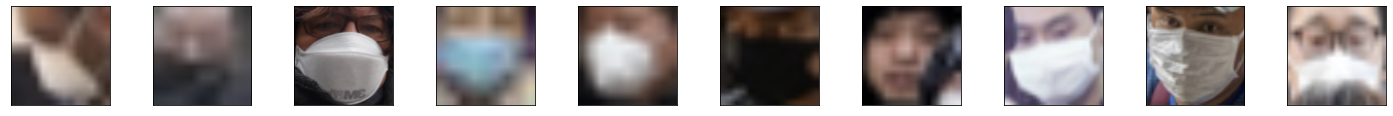

In [40]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
    
train_features_np = X.numpy()
fig = plt.figure(figsize = (25,4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(train_features_np[idx], (1,2,0)))

# DenseNet Model

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [42]:
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, recall_score, balanced_accuracy_score
def evaluate_accuracy(test_iter, net, device=device):
    pred_all = []
    label_all = []
    metric = [0, 0]
    with torch.no_grad():
        for X, y in test_iter:
            net.eval()
            X = X.to(device)
            y = y.to(device)
            net = net.to(device)
            y_hat = net(X)
            metric[0] += (y_hat.argmax(dim=1) == y).sum().item()
            metric[1] += len(y)
            pred_all.extend(y_hat.argmax(dim=1).cpu())
            label_all.extend(y.cpu())
            l_loss = loss(y_hat, y)
            
        precision = precision_score(label_all,pred_all,average='macro')
        recall = recall_score(label_all,pred_all,average='macro')
        f1 = f1_score(label_all,pred_all,average='macro')
        bal = balanced_accuracy_score(label_all,pred_all)
            
    return l_loss.item(), metric[0]/metric[1], precision, recall, f1, bal

def metricss(y_true, y_pred):
    pre = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    bal = balanced_accuracy_score(y_true, y_pred)
    return {'1pre': pre,'2recall': recall,'3f1': f1,'4bal': bal}

Fold 1
epoch0	loss	acc	pre	recall	f1	bal
train	3.6609	0.5755	0.0034	0.0017	0.0021	0.4478
test	0.3687	0.9203	0.3466	0.3511	0.3486	0.8778
epoch1	loss	acc	pre	recall	f1	bal
train	0.0918	0.9763	0.4868	0.4741	0.4802	0.9483
test	0.0197	0.9633	0.6348	0.6123	0.6229	0.9185
epoch2	loss	acc	pre	recall	f1	bal
train	0.0259	0.9940	0.9903	0.9897	0.9900	0.9897
test	0.0749	0.9696	0.4776	0.4701	0.4738	0.9401
epoch3	loss	acc	pre	recall	f1	bal
train	0.0138	0.9981	0.9968	0.9968	0.9968	0.9968
test	0.0526	0.9709	0.4781	0.4719	0.4750	0.9439
epoch4	loss	acc	pre	recall	f1	bal
train	0.0090	0.9994	0.9983	0.9996	0.9989	0.9996
test	0.0097	0.9696	0.4776	0.4701	0.4738	0.9401
epoch5	loss	acc	pre	recall	f1	bal
train	0.0069	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.0524	0.9747	0.4796	0.4775	0.4786	0.9551
epoch6	loss	acc	pre	recall	f1	bal
train	0.0075	0.9997	0.9998	0.9991	0.9995	0.9991
test	0.0050	0.9747	0.6389	0.6347	0.6368	0.9521
epoch7	loss	acc	pre	recall	f1	bal
train	0.0047	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.1

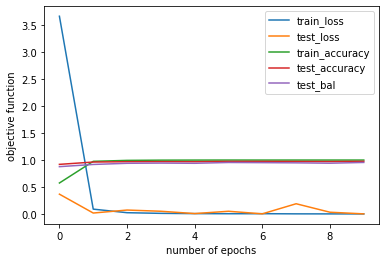


Fold 2
epoch0	loss	acc	pre	recall	f1	bal
train	3.5797	0.5790	0.0033	0.0017	0.0021	0.4584
test	0.1244	0.9304	0.3580	0.3413	0.3490	0.8532
epoch1	loss	acc	pre	recall	f1	bal
train	0.0811	0.9775	0.6457	0.6381	0.6418	0.9571
test	0.0092	0.9772	0.6437	0.6375	0.6406	0.9563
epoch2	loss	acc	pre	recall	f1	bal
train	0.0270	0.9943	0.6622	0.6586	0.6604	0.9879
test	0.1347	0.9747	0.9599	0.9488	0.9542	0.9488
epoch3	loss	acc	pre	recall	f1	bal
train	0.0129	0.9981	0.9982	0.9955	0.9968	0.9955
test	0.0171	0.9785	0.9683	0.9541	0.9610	0.9541
epoch4	loss	acc	pre	recall	f1	bal
train	0.0102	0.9994	0.9989	0.9989	0.9989	0.9989
test	0.0453	0.9759	0.9583	0.9556	0.9569	0.9556
epoch5	loss	acc	pre	recall	f1	bal
train	0.0059	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.1015	0.9785	0.9603	0.9631	0.9617	0.9631
epoch6	loss	acc	pre	recall	f1	bal
train	0.0053	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.1774	0.9759	0.9583	0.9556	0.9569	0.9556
epoch7	loss	acc	pre	recall	f1	bal
train	0.0051	0.9997	0.9998	0.9991	0.9995	0.9991
test	0.

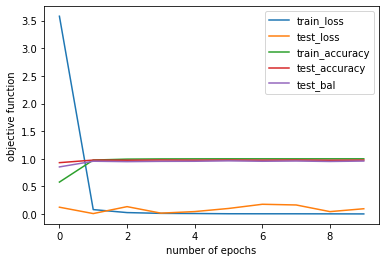


Fold 3
epoch0	loss	acc	pre	recall	f1	bal
train	3.6510	0.5657	0.0034	0.0016	0.0021	0.4400
test	0.2115	0.9038	0.1509	0.1439	0.1474	0.8636
epoch1	loss	acc	pre	recall	f1	bal
train	0.0856	0.9740	0.9621	0.9494	0.9556	0.9494
test	0.0275	0.9646	0.9723	0.9088	0.9367	0.9088
epoch2	loss	acc	pre	recall	f1	bal
train	0.0337	0.9905	0.9873	0.9806	0.9839	0.9806
test	0.0320	0.9810	0.9826	0.9536	0.9674	0.9536
epoch3	loss	acc	pre	recall	f1	bal
train	0.0130	0.9991	0.9981	0.9987	0.9984	0.9987
test	0.0622	0.9835	0.9871	0.9578	0.9717	0.9578
epoch4	loss	acc	pre	recall	f1	bal
train	0.0080	0.9994	0.9996	0.9983	0.9989	0.9983
test	0.0030	0.9848	0.9850	0.9640	0.9741	0.9640
epoch5	loss	acc	pre	recall	f1	bal
train	0.0060	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.0351	0.9873	0.9867	0.9709	0.9785	0.9709
epoch6	loss	acc	pre	recall	f1	bal
train	0.0056	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.0147	0.9861	0.9887	0.9647	0.9762	0.9647
epoch7	loss	acc	pre	recall	f1	bal
train	0.0043	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.

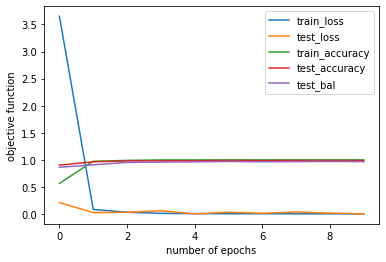


Fold 4
epoch0	loss	acc	pre	recall	f1	bal
train	3.6300	0.5764	0.0034	0.0017	0.0021	0.4451
test	0.3466	0.8848	0.2950	0.2438	0.2595	0.7315
epoch1	loss	acc	pre	recall	f1	bal
train	0.0892	0.9721	0.9598	0.9444	0.9518	0.9444
test	0.0086	0.9797	0.9673	0.9673	0.9673	0.9673
epoch2	loss	acc	pre	recall	f1	bal
train	0.0235	0.9953	0.9950	0.9888	0.9919	0.9888
test	0.0156	0.9759	0.9580	0.9649	0.9614	0.9649
epoch3	loss	acc	pre	recall	f1	bal
train	0.0123	0.9987	0.9992	0.9965	0.9978	0.9965
test	0.0507	0.9772	0.9700	0.9556	0.9626	0.9556
epoch4	loss	acc	pre	recall	f1	bal
train	0.0095	0.9994	0.9996	0.9982	0.9989	0.9982
test	0.0124	0.9785	0.9686	0.9614	0.9649	0.9614
epoch5	loss	acc	pre	recall	f1	bal
train	0.0079	0.9994	0.9989	0.9989	0.9989	0.9989
test	0.2834	0.9797	0.9718	0.9622	0.9669	0.9622
epoch6	loss	acc	pre	recall	f1	bal
train	0.0059	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.0028	0.9772	0.9654	0.9606	0.9630	0.9606
epoch7	loss	acc	pre	recall	f1	bal
train	0.0049	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.

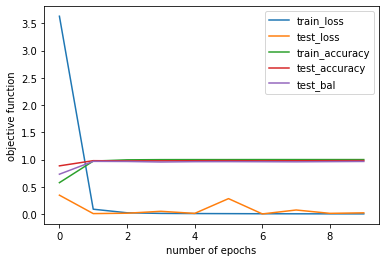


Fold 5
epoch0	loss	acc	pre	recall	f1	bal
train	3.6292	0.5718	0.0033	0.0016	0.0021	0.4397
test	0.1320	0.8948	0.1592	0.1529	0.1560	0.8412
epoch1	loss	acc	pre	recall	f1	bal
train	0.0808	0.9772	0.6421	0.6398	0.6409	0.9597
test	0.0101	0.9582	0.9655	0.9002	0.9286	0.9002
epoch2	loss	acc	pre	recall	f1	bal
train	0.0264	0.9927	0.9906	0.9844	0.9875	0.9844
test	0.0241	0.9696	0.9675	0.9344	0.9498	0.9344
epoch3	loss	acc	pre	recall	f1	bal
train	0.0123	0.9987	0.9978	0.9978	0.9978	0.9978
test	0.2645	0.9683	0.9616	0.9360	0.9482	0.9360
epoch4	loss	acc	pre	recall	f1	bal
train	0.0077	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.0194	0.9772	0.9778	0.9489	0.9626	0.9489
epoch5	loss	acc	pre	recall	f1	bal
train	0.0061	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.0266	0.9734	0.9727	0.9417	0.9562	0.9417
epoch6	loss	acc	pre	recall	f1	bal
train	0.0055	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.0649	0.9721	0.9693	0.9409	0.9543	0.9409
epoch7	loss	acc	pre	recall	f1	bal
train	0.0054	0.9997	0.9998	0.9991	0.9995	0.9991
test	0.

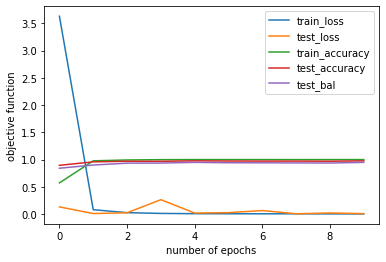


[0.97974106 0.90777547 0.89583293 0.90154851 0.95955471]


In [44]:
k = 5
batch_size = 128
splits = kfold(n_splits=k, shuffle=True)#, random_state=42)
results = [0, 0, 0, 0, 0]
accuracy = []

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(no_incorrect)))):
    print('Fold {}'.format(fold + 1))
    
    densenets = models.densenet161(pretrained=True)

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_iter = DataLoader(no_incorrect, batch_size=batch_size, sampler=train_sampler)
    test_iter = DataLoader(no_incorrect, batch_size=batch_size, sampler=test_sampler)
    
    try:
        model3 = densenets
        for param in model3.parameters():
            param.requires_grad=True
        optimizer = optim.SGD(model3.parameters(), lr=1e-3, momentum=0.8)
        loss = nn.CrossEntropyLoss()
        since = time.time()

        num_epochs = 10
        training_history = {"train_loss": [], "train_accuracy": [], "epoch": [], "test_loss": [], "test_accuracy": [], "test_bal":[]}
        model3 = model3.to(device)

        for epoch in range(num_epochs):
            metric = [0, 0, 0]
            model3.train()
            total_y, total_pred_label = [], []

            for X, y in train_iter:
                X = X.to(device)
                y = y.to(device)
                y_hat = model3(X)
                l = loss(y_hat, y)
                optimizer.zero_grad()
                l.backward()
                optimizer.step()
                metric[0] += l.item()*len(y)
                metric[1] += (y_hat.argmax(dim=1) == y).sum().item()
                metric[2] += len(y)

                total_y.extend(y.cpu())
                total_pred_label.extend(y_hat.argmax(dim=1).cpu())

            with torch.no_grad():
                train_l = metric[0]/metric[2]
                train_acc = metric[1]/metric[2]
                test_l, test_acc, test_pre,test_recall,test_f1, test_bal = evaluate_accuracy(test_iter, model3, device)

                metric_score = metricss(np.array(total_y), np.array(total_pred_label))
                sorted_metric_score = sorted(metric_score.items(), key=lambda x: x[0])
                metrics_string = '\t'.join(['loss'] +['acc']+ [metric_name[1:] for metric_name, _ in sorted_metric_score])
                score_string = '\t'.join(['{:.4f}'.format(train_l)] + ['{:.4f}'.format(train_acc)]+['{:.4f}'.format(score) for _, score in sorted_metric_score])
                print("{}{}\t{}".format('epoch', epoch, metrics_string))
                print("{}{}\t{}".format('train', '', score_string))

                training_history["train_loss"].append(train_l)
                training_history["train_accuracy"].append(train_acc)    
                training_history["epoch"].append(epoch)
                training_history["test_loss"].append(test_l)
                training_history["test_accuracy"].append(test_acc)
                training_history["test_bal"].append(test_bal)
                print("{}{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}".format('test', '', test_l, test_acc, test_pre, test_recall, test_f1, test_bal))


        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        plt.plot(training_history["epoch"], training_history["train_loss"])
        plt.plot(training_history["epoch"], training_history["test_loss"])
        plt.plot(training_history["epoch"], training_history["train_accuracy"])
        plt.plot(training_history["epoch"], training_history["test_accuracy"])
        plt.plot(training_history["epoch"], training_history["test_bal"])

        plt.xlabel("number of epochs")
        plt.ylabel("objective function")
        plt.legend(["train_loss","test_loss","train_accuracy", "test_accuracy", "test_bal"])
        plt.show()
        results[0] += test_acc
        results[1] += test_pre
        results[2] += test_recall
        results[3] += test_f1
        results[4] += test_bal
        #accuracy.append(training_history['test_accuracy'][-1])
    except:
        accuracy.append(0)
    print()
print(np.array(results) / 5)

# Grad-CAM

In [ ]:
model = model3

In [68]:
features_fn = model.features
classifier_fn = nn.Sequential(*([nn.AvgPool2d(7, 1), Flatten()] + [model.classifier]))

In [37]:
class Flatten(nn.Module):
    """One layer module that flattens its input."""
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)
features_fn = model.features
classifier_fn = nn.Sequential(*([nn.AvgPool2d(7, 1), Flatten()] + [model.classifier]))

In [95]:
def GradCAM(img, c, features_fn, classifier_fn):
    feats = features_fn(img.cuda())
    _, N, H, W = feats.size()
    out = classifier_fn(feats)
    c_score = out[0, c]
    grads = torch.autograd.grad(c_score, feats)
    w = grads[0][0].mean(-1).mean(-1)
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal

In [84]:
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [92]:
testset[0][0].shape, testset[0][1]

(torch.Size([3, 96, 96]), tensor(0))

In [46]:
pip install pytorch-gradcam

     |████████████████████████████████| 6.0 MB 901 kB/s eta 0:00:01
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5269 sha256=01143f5de9729b58f944cb9db2ec84c42196950e92639906365fc8b50716c7c1
  Stored in directory: /root/.cache/pip/wheels/06/e7/da/b13a71980c3a787414e5ff8e156701c561c6322636396d71cc
Successfully built pytorch-gradcam
Note: you may need to restart the kernel to use updated packages.


In [47]:
pip install grad-cam

     |████████████████████████████████| 7.8 MB 896 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38242 sha256=d93aed46a9843f3f4b70b34ce03bc6ec34e6cc467a49d7e38692673e47af67b0
  Stored in directory: /root/.cache/pip/wheels/a4/6a/11/fa213a7aaae1a99a800b86bdd1cc95bc9c7d7914b0859663b8
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


In [48]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
target_layers = [model.features[-1]]
input_tensor = testset[0][0]

In [135]:
import requests
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image

In [52]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import torchvision
import torch.nn as nn

In [49]:
model3 = models.resnet50(pretrained=True)

n_inputs = model3.fc.in_features
last_layer = nn.Linear(n_inputs, 2)
model3.fc.out_features = last_layer
print('reinitialize model with output features as 2 :', model3.fc.out_features)
optimizer = optim.SGD(model3.parameters(), lr=1e-3, momentum=0.8)
loss = nn.CrossEntropyLoss()
import time
since = time.time()

num_epochs = 10
training_history = {"train_loss": [], "train_accuracy": [], "epoch": [], "test_loss": [], "test_accuracy": []}
model3 = model3.to(device)

for epoch in range(num_epochs):
    metric = [0, 0, 0]
    model3.train()
    total_y, total_pred_label = [], []
    
    for X, y in train_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = model3(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric[0] += l.item()*len(y)
        metric[1] += (y_hat.argmax(dim=1) == y).sum().item()
        metric[2] += len(y)
        
        total_y.extend(y.cpu())
        total_pred_label.extend(y_hat.argmax(dim=1).cpu())

    with torch.no_grad():
        train_l = metric[0]/metric[2]
        train_acc = metric[1]/metric[2]
        test_l, test_acc, test_pre,test_recall,test_f1, test_bal = evaluate_accuracy(test_iter, model3, device)
    
        metric_score = metricss(np.array(total_y), np.array(total_pred_label))
        sorted_metric_score = sorted(metric_score.items(), key=lambda x: x[0])
        metrics_string = '\t'.join(['loss'] +['acc']+ [metric_name[1:] for metric_name, _ in sorted_metric_score])
        score_string = '\t'.join(['{:.4f}'.format(train_l)] + ['{:.4f}'.format(train_acc)]+['{:.4f}'.format(score) for _, score in sorted_metric_score])
        print("{}{}\t{}".format('epoch', epoch, metrics_string))
        print("{}{}\t{}".format('train', '', score_string))

        training_history["train_loss"].append(train_l)
        training_history["train_accuracy"].append(train_acc)    
        training_history["epoch"].append(epoch)
        training_history["test_loss"].append(test_l)
        training_history["test_accuracy"].append(test_acc)
        print("{}{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}".format('test', '', test_l, test_acc, test_pre, test_recall, test_f1))
        
        
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

reinitialize model with output features as 2 : Linear(in_features=2048, out_features=2, bias=True)
epoch0	loss	acc	pre	recall	f1	bal
train	3.8962	0.5532	0.0031	0.0014	0.0018	0.4256
test	0.3108	0.9252	0.4342	0.4596	0.4450
epoch1	loss	acc	pre	recall	f1	bal
train	0.0863	0.9763	0.3218	0.3181	0.3199	0.9543
test	0.0490	0.9645	0.4727	0.4730	0.4728
epoch2	loss	acc	pre	recall	f1	bal
train	0.0267	0.9943	0.9916	0.9889	0.9902	0.9889
test	0.0656	0.9670	0.3834	0.3761	0.3796
epoch3	loss	acc	pre	recall	f1	bal
train	0.0124	0.9991	0.9987	0.9980	0.9984	0.9980
test	0.1100	0.9721	0.3887	0.3773	0.3827
epoch4	loss	acc	pre	recall	f1	bal
train	0.0084	0.9987	0.9972	0.9985	0.9978	0.9985
test	0.0247	0.9683	0.3856	0.3754	0.3803
epoch5	loss	acc	pre	recall	f1	bal
train	0.0053	1.0000	1.0000	1.0000	1.0000	1.0000
test	0.0785	0.9708	0.3873	0.3770	0.3819
epoch6	loss	acc	pre	recall	f1	bal
train	0.0057	0.9997	0.9991	0.9998	0.9995	0.9998
test	0.0072	0.9708	0.4825	0.4713	0.4767
epoch7	loss	acc	pre	recall	f1	bal
train	0.0039	

In [50]:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import DropInConfidence, IncreaseInConfidence

The confidence increase percent: 2.7220817599982183e-06
The visualization of the pertubated image for the metric:


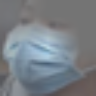

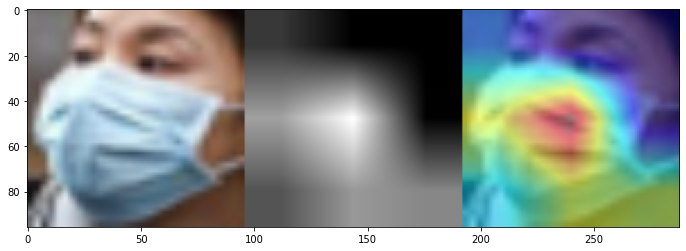

In [253]:
model = model3
model.eval()

for X, y in train_iter:
    X = X
    y = y
train_features_np = X.numpy()
fig = plt.figure(figsize = (25,4))
for idx in np.arange(1):
    this_image = train_features_np[idx]
    img = np.transpose(this_image, (1,2,0))
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.to(device), targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
plt.imshow(Image.fromarray(images))

targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor.to(device), grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase percent: 2.7220817599982183e-06
The visualization of the pertubated image for the metric:


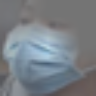

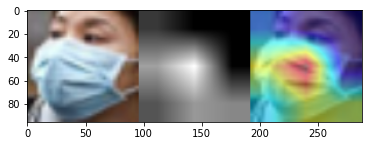

In [262]:
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.to(device), targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
plt.imshow(Image.fromarray(images))

targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor.to(device), grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

In [257]:
print("Drop in confidence", DropInConfidence()(input_tensor.to(device), grayscale_cams, targets, model))
print("Increase in confidence", IncreaseInConfidence()(input_tensor.to(device), grayscale_cams, targets, model))

Drop in confidence [0.]
Increase in confidence [1.]


The confidence increase percent: 3.559401731689782e-11
The visualization of the pertubated image for the metric:


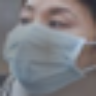

In [258]:
inverse_cams = 1 - grayscale_cams
scores, visualizations = CamMultImageConfidenceChange()(input_tensor.to(device), inverse_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase percent: 8.285886679004761e-05
The visualization of the pertubated image for the metric:


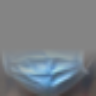

In [222]:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor.to(device), grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase percent: 6.063505253450785e-07
The visualization of the pertubated image for the metric:


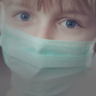

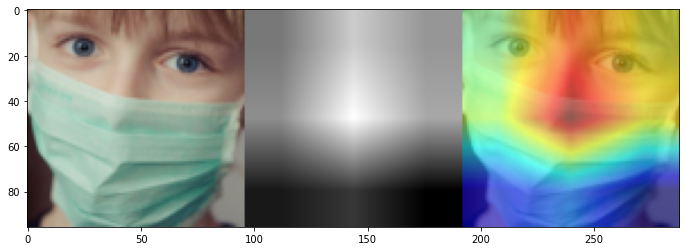

In [76]:
model = model3
model.eval()

for X, y in train_iter:
    X = X
    y = y
train_features_np = X.numpy()
fig = plt.figure(figsize = (25,4))
for idx in np.arange(1):
    this_image = train_features_np[idx]
    img = np.transpose(this_image, (1,2,0))
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.to(device), targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
plt.imshow(Image.fromarray(images))

targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor.to(device), grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase percent: 4.238122006117173e-09
The visualization of the pertubated image for the metric:


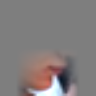

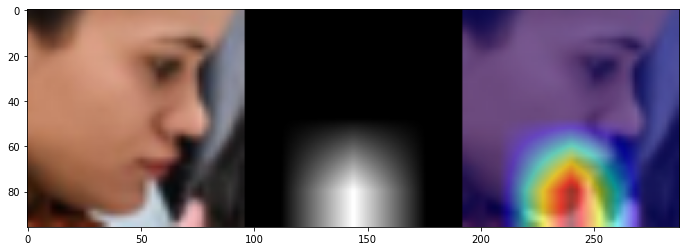

In [80]:
model = model3
model.eval()

for X, y in train_iter:
    X = X
    y = y
train_features_np = X.numpy()
fig = plt.figure(figsize = (25,4))
for idx in np.arange(1):
    this_image = train_features_np[idx]
    img = np.transpose(this_image, (1,2,0))
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.to(device), targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
plt.imshow(Image.fromarray(images))

targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor.to(device), grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase percent: 2.0032751990584075e-05
The visualization of the pertubated image for the metric:


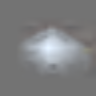

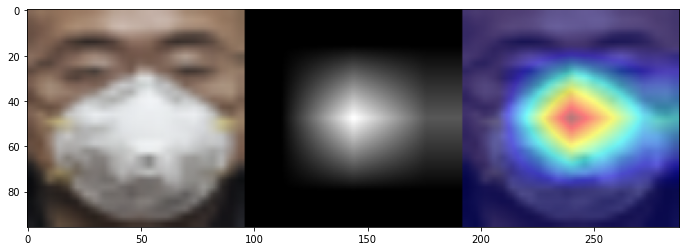

In [81]:
model = model3
model.eval()

for X, y in train_iter:
    X = X
    y = y
train_features_np = X.numpy()
fig = plt.figure(figsize = (25,4))
for idx in np.arange(1):
    this_image = train_features_np[idx]
    img = np.transpose(this_image, (1,2,0))
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.to(device), targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
plt.imshow(Image.fromarray(images))

targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor.to(device), grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

The confidence increase percent: 7.615443831099356e-08
The visualization of the pertubated image for the metric:


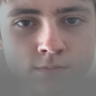

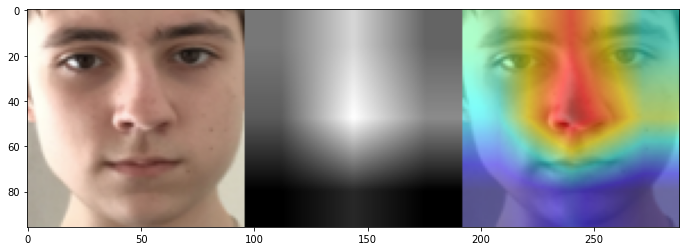

In [135]:
model = model3
model.eval()

for X, y in train_iter:
    X = X
    y = y
train_features_np = X.numpy()
fig = plt.figure(figsize = (25,4))
for idx in np.arange(1):
    this_image = train_features_np[idx]
    img = np.transpose(this_image, (1,2,0))
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor.to(device), targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
plt.imshow(Image.fromarray(images))

targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor.to(device), grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)